# ECG‑XAI Demo

This notebook is the **demo runner** for the ECG‑XAI project on Kaggle.
The code can be obtained from: https://github.com/nareshwar/ecg-xai

## Process
1. **Setup**: clone + install (quietly), import TensorFlow with GPU logging suppressed.
2. **Load artifacts** from Kaggle Inputs:
   - pre-trained ResNet model (from an input called `resnet`)
   - cached arrays (from an input called `metadata`)
3. **Selection cache**: build `sel_df` once, then reuse it from `/kaggle/working/cache/`.
4. **Explainability**: run fused **LIME + TimeSHAP** on a small demo subset (or full eval mode).
5. **Evaluation** + **Extra-beat stability**: produce CSV outputs + (optional) plots.
6. **Outputs** are written to `/kaggle/working/outputs/`.

> Kaggle Inputs (`/kaggle/input/...`) are **read-only**. Caches/outputs must go to `/kaggle/working/...`.

In [1]:
# --- Configuration (edit this cell only) ---
from dataclasses import dataclass

@dataclass
class RunConfig:
    run_mode: str = "demo"  # "demo" or "eval"
    seed: int = 1234
    # caching
    force_recompute_sel_df: bool = False
    # demo knobs
    max_examples_per_class: int = 3
    plot: bool = True
    # logging
    quiet_pip: bool = True
    quiet_tf: bool = True

CFG = RunConfig()

if CFG.run_mode == "eval":
    CFG.max_examples_per_class = 50
    CFG.plot = False

print(CFG)

RunConfig(run_mode='demo', seed=1234, force_recompute_sel_df=False, max_examples_per_class=3, plot=True, quiet_pip=True, quiet_tf=True)


## Quick start: what this notebook does (and how long it takes)

**Two modes**
- **demo** (default): runs a few examples per class and plots intermediate results.
- **eval**: runs the full selection set and writes CSV outputs; plotting is off for speed.

**Hardware**
- Works on CPU, but a **GPU is recommended** if you want the notebook to feel interactive.
- Memory: plan for **~8–16 GB RAM** (more if you increase `max_examples_per_class`).

**Typical runtime (ballpark)**
- **Per record**: LIME ≈ *tens of seconds*, TimeSHAP ≈ *~1–3 minutes* (depends heavily on CPU/GPU and window size).
- **demo mode**: usually a few minutes end-to-end.
- **eval mode**: can be **tens of minutes to hours**, depending on how many records you evaluate.

Tip: the “What the user gets” cell below shows one end‑to‑end fused example early, so the notebook doesn’t feel batch‑oriented.

In [2]:
# --- Environment / logging (do this BEFORE importing TensorFlow) ---
import os
from pathlib import Path

# keep notebook output tidy
if CFG.quiet_tf:
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # hide INFO/WARN; keep errors
# helpful on some Kaggle GPU images
os.environ.setdefault("XLA_FLAGS", "--xla_gpu_cuda_data_dir=/usr/local/cuda")

PIP_LOG = Path("/kaggle/working/pip_warnings.log")
TF_LOG  = Path("/kaggle/working/tf_init.log")

## 1) Clone repo and install

In [3]:
# --- Clone repo (idempotent) ---
from pathlib import Path
import shutil

%cd /kaggle/working

REPO_DIR = Path("/kaggle/working/ecg-xai")
if REPO_DIR.exists():
    shutil.rmtree(REPO_DIR)

!git clone --depth 1 https://github.com/nareshwar/ecg-xai.git
%cd ecg-xai

REPO_ROOT = Path.cwd()
print("REPO_ROOT =", REPO_ROOT)

/kaggle/working
Cloning into 'ecg-xai'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (371/371), done.ts:  99% (368/371)
remote: Compressing objects: 100% (362/362), done.
remote: Total 371 (delta 13), reused 345 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (371/371), 19.18 MiB | 30.44 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/kaggle/working/ecg-xai
REPO_ROOT = /kaggle/working/ecg-xai


In [4]:
# --- Quiet install ---
# Kaggle ships a large preinstalled environment. Pip may print dependency-conflict warnings even when installs succeed.
# We redirect pip stderr to a log so your showcase notebook stays clean.

import subprocess, sys

PIP_LOG.write_text("")  # truncate

def pip_install(args):
    cmd = [sys.executable, "-m", "pip"] + args
    with PIP_LOG.open("a") as log:
        subprocess.check_call(cmd, stdout=subprocess.DEVNULL if CFG.quiet_pip else None, stderr=log)

# Install your project without forcing pip to "fix" the whole Kaggle image
pip_install(["install", ".", "--no-deps", "-q"])

# Install only the runtime extras this notebook needs
pip_install(["install", "ecg-plot", "kaleido", "-q"])

print("Installed. pip warnings ->", PIP_LOG)

Installed. pip warnings -> /kaggle/working/pip_warnings.log


## 2) Imports and GPU sanity check

In [6]:
# --- Import TensorFlow quietly (capture init logs) ---
import contextlib

with contextlib.redirect_stderr(TF_LOG.open("w")):
    import tensorflow as tf

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
print("TF init log ->", TF_LOG)

TF: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TF init log -> /kaggle/working/tf_init.log


In [8]:
# --- Standard python modules ---
import numpy as np
import pandas as pd
import zlib
from datetime import datetime
from pathlib import Path

# --- Import project specific modules ---
from ecgxai.utils import save_run, load_run
from ecgxai.config_targets import TARGET_META
from ecgxai.explainer import run_fused_pipeline_for_classes
from ecgxai.selection import build_selection_df_with_aliases
from ecgxai.stability_eval import run_extra_beat_stability_experiment
from ecgxai.eval import evaluate_all_payloads

%load_ext autoreload
%autoreload 2

print("Imports OK!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imports OK!


## 3) Paths (Kaggle Inputs + Writable caches/outputs)

### Inputs and outputs (plain English)

**Required Kaggle Inputs**
- **`/kaggle/input/resnet/`**: the trained classifier (expected at `keras/default/1/resnet_final.keras` or `resnet_final.h5`)
- **`/kaggle/input/metadata/`**:
  - `ecg_filenames.npy` — list of record IDs/filenames aligned to rows of `probs`/`y_true`
  - `ecg_model_probs.npy` — *precomputed* model probabilities for each record (used for selection/filtering)
  - `ecg_y_true.npy` — ground-truth multi-label targets (same row order as `probs`)
  - `snomed_classes.npy` — the SNOMED class list (column order for `probs`/`y_true`)

**Optional Inputs (speed-ups)**
- `sel_df_cache.npz` — cached selection dataframe (skips duration checks/filtering)
- `ecg_durations.npy` — cached record durations
- `df_lime_all.pkl`, `df_ts_all.pkl` — cached explanation results (skips recomputing LIME/TimeSHAP)

**Outputs (written to `/kaggle/working/outputs`)**
- `df_eval_attauc_deletion.csv` — explanation quality metrics (e.g., plausibility + deletion faithfulness)
- `df_eval_stability.csv` — stability metrics (extra heartbeat perturbation)
- `ecg_xai_sel_meta.csv` — the selected records metadata used in the run

In [9]:
# --- Paths ---
META_IN  = Path("/kaggle/input/metadata")  # expects: ecg_filenames.npy, ecg_model_probs.npy, ecg_y_true.npy, snomed_classes.npy
MODEL_IN = Path("/kaggle/input/resnet")    # expects: keras/default/1/resnet_final.(h5|keras)

CACHE_DIR = Path("/kaggle/working/cache")
OUT_DIR   = Path("/kaggle/working/outputs")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# inputs
ECG_FILENAMES_PATH = META_IN / "ecg_filenames.npy"
PROBS_PATH         = META_IN / "ecg_model_probs.npy"
Y_TRUE_PATH        = META_IN / "ecg_y_true.npy"
CLASS_NAMES_PATH   = META_IN / "snomed_classes.npy"

# optional input cache (if you published it)
SEL_DF_INPUT_CACHE = META_IN / "sel_df_cache.npz"

# writable cache/output
SEL_DF_CACHE_PATH  = CACHE_DIR / "sel_df_cache.npz"
ECG_DURATIONS_PATH = CACHE_DIR / "ecg_durations.npy"

# model
MODEL_H5    = MODEL_IN / "keras" / "default" / "1" / "resnet_final.h5"
MODEL_KERAS = MODEL_IN / "keras" / "default" / "1" / "resnet_final.keras"
MODEL_PATH  = MODEL_H5 if MODEL_H5.exists() else MODEL_KERAS

# outputs
STAB_OUT_DIR  = OUT_DIR / "extra_beat_aug"
STAB_OUT_DIR.mkdir(parents=True, exist_ok=True)

EVAL_CSV_PATH = OUT_DIR / "df_eval_attauc_deletion.csv"
STAB_CSV_PATH = OUT_DIR / "df_eval_stability.csv"
ECG_PRED_PATH = OUT_DIR / "ecg_xai_sel_meta.csv"

print("MODEL_PATH:", MODEL_PATH, "| exists:", MODEL_PATH.exists())
print("META_IN exists:", META_IN.exists())
for p in [ECG_FILENAMES_PATH, PROBS_PATH, Y_TRUE_PATH, CLASS_NAMES_PATH]:
    print(" -", p.name, "exists:", p.exists())

# --- Guardrails: fail fast with a friendly message if Kaggle Inputs are missing ---
required = {
    "Model file": MODEL_PATH,
    "ecg_filenames.npy": ECG_FILENAMES_PATH,
    "ecg_model_probs.npy": PROBS_PATH,
    "ecg_y_true.npy": Y_TRUE_PATH,
    "snomed_classes.npy": CLASS_NAMES_PATH,
}
missing = {k: v for k, v in required.items() if not v.exists()}

if missing:
    msg = [
        "Missing required Kaggle Inputs.",
        "",
        "Please add TWO Kaggle Inputs with these folder names and expected files:",
        "1) Input folder: **metadata**  -> /kaggle/input/metadata/",
        "   - ecg_filenames.npy",
        "   - ecg_model_probs.npy",
        "   - ecg_y_true.npy",
        "   - snomed_classes.npy",
        "2) Input folder: **resnet**     -> /kaggle/input/resnet/",
        "   - keras/default/1/resnet_final.keras   (or resnet_final.h5)",
        "",
        "Missing in this run:",
    ]
    for k, v in missing.items():
        msg.append(f" - {k}: expected at {v}")
    raise FileNotFoundError("\n".join(msg))


MODEL_PATH: /kaggle/input/resnet/keras/default/1/resnet_final.keras | exists: True
META_IN exists: True
 - ecg_filenames.npy exists: True
 - ecg_model_probs.npy exists: True
 - ecg_y_true.npy exists: True
 - snomed_classes.npy exists: True


## 4) Load model + metadata arrays

In [11]:
# --- Load model (with a safe fallback for mislabeled .keras files) ---
import shutil, zipfile

def maybe_rename_keras_to_h5(src_path: Path) -> Path:
    """If src_path endswith .keras but is actually HDF5, copy+rename to .h5 for Keras 3 compatibility."""
    if src_path.suffix.lower() != ".keras":
        return src_path
    with src_path.open("rb") as f:
        magic = f.read(8)
    if magic == b"\x89HDF\r\n\x1a\n":
        dst = Path("/kaggle/working") / (src_path.stem + ".h5")
        shutil.copy2(src_path, dst)
        print("HDF5 detected with .keras extension. Copied+renamed to:", dst)
        return dst
    # if it's a real .keras zip, keep it
    return src_path

LOAD_MODEL_PATH = maybe_rename_keras_to_h5(MODEL_PATH)
model = tf.keras.models.load_model(str(LOAD_MODEL_PATH), compile=False)
print("Loaded model:", LOAD_MODEL_PATH)

HDF5 detected with .keras extension. Copied+renamed to: /kaggle/working/resnet_final.h5
Loaded model: /kaggle/working/resnet_final.h5


In [13]:
# --- 8) Load arrays from metadata input ---
ecg_filenames = np.load(ECG_FILENAMES_PATH, allow_pickle=True)
probs         = np.load(PROBS_PATH)
y_true        = np.load(Y_TRUE_PATH)
class_names   = np.load(CLASS_NAMES_PATH, allow_pickle=True)

print("ecg_filenames:", len(ecg_filenames))
print("probs shape :", probs.shape)
print("y_true shape:", y_true.shape)
print("n_classes   :", len(class_names))

ecg_filenames: 43101
probs shape : (43101, 27)
y_true shape: (43101, 27)
n_classes   : 27


## 5) Build or load selection dataframe (`sel_df`)

In [14]:
# --- Small helpers to cache a DataFrame as NPZ ---
def save_df_npz(df: pd.DataFrame, path: Path):
    arr = df.to_records(index=False)
    np.savez_compressed(path, data=arr)

def load_df_npz(path: Path) -> pd.DataFrame:
    with np.load(path, allow_pickle=True) as z:
        return pd.DataFrame.from_records(z["data"])

# --- Load selection cache (Input -> Working) or compute ---
if (not CFG.force_recompute_sel_df) and SEL_DF_CACHE_PATH.exists():
    sel_df = load_df_npz(SEL_DF_CACHE_PATH)
    print("Loaded sel_df cache:", SEL_DF_CACHE_PATH)

elif (not CFG.force_recompute_sel_df) and SEL_DF_INPUT_CACHE.exists():
    sel_df = load_df_npz(SEL_DF_INPUT_CACHE)
    print("Loaded sel_df cache from INPUT:", SEL_DF_INPUT_CACHE)
    save_df_npz(sel_df, SEL_DF_CACHE_PATH)
    print("Copied sel_df cache to:", SEL_DF_CACHE_PATH)

else:
    sel_df = build_selection_df_with_aliases(
        ecg_filenames=ecg_filenames,
        probs=probs,
        class_names=class_names,
        target_meta=TARGET_META,
        y_true=y_true,
        k_per_class=50,
        min_prob=0.85,
        max_duration_sec=20.0,
        duration_cache_path=str(ECG_DURATIONS_PATH),
    )
    save_df_npz(sel_df, SEL_DF_CACHE_PATH)
    print("Built + saved sel_df cache:", SEL_DF_CACHE_PATH)

# convenience CSV for inspection
sel_df.to_csv(ECG_PRED_PATH, index=False)
print("Saved selection CSV:", ECG_PRED_PATH)

sel_df
sel_df.columns.tolist()


Loaded sel_df cache: /kaggle/working/cache/sel_df_cache.npz
Saved selection CSV: /kaggle/working/outputs/ecg_xai_sel_meta.csv


['group_class', 'filename', 'sel_idx', 'duration_sec', 'prob_meta']

### 5.1) What the user gets (single example, end‑to‑end)

This cell shows **one** record with a **fused LIME+TimeSHAP explanation** and a **one‑row summary table** (probability, top spans, and metrics).

In [15]:
import time
import numpy as np
import pandas as pd

from ecgxai.plot import plot_from_payload
from ecgxai.explainer import default_explainer_config
from ecgxai.payload import payload_from_lime_row, payload_from_timeshap_row
from ecgxai.fusion import fuse_lime_timeshap_payload
from ecgxai.ecg_lime import run_lime_for_one_class_from_sel
from ecgxai.ecg_timeshap import run_timeshap_for_one_class_from_sel
from ecgxai.eval import evaluate_all_payloads


def _safe_class_idx(class_names, cls_code: str):
    cls_arr = np.array(class_names).astype(str)
    hits = np.where(cls_arr == str(cls_code))[0]
    return int(hits[0]) if len(hits) else None

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _is_span_dict(d):
    if not isinstance(d, dict):
        return False
    ks = set(d.keys())
    return (
        {"start","end"}.issubset(ks) or
        {"t0","t1"}.issubset(ks) or
        {"i0","i1"}.issubset(ks) or
        {"start_idx","end_idx"}.issubset(ks)
    )

def _extract_top_spans(payload, max_items=5):
    # recursive best-effort: finds any list of span-like dicts inside payload
    stack = [payload]
    while stack:
        obj = stack.pop()
        if isinstance(obj, list) and obj:
            sample = obj[: min(3, len(obj))]
            if all(_is_span_dict(x) for x in sample):
                return obj[:max_items]
            for x in obj:
                if isinstance(x, (dict, list)):
                    stack.append(x)
        elif isinstance(obj, dict):
            for v in obj.values():
                if isinstance(v, (dict, list)):
                    stack.append(v)
    return []


def run_demo_for_class(
    class_code,
    pick="maxprob",          # "maxprob" or "first"
    val_idx_override=None,   # set to an int if you want a specific record
    topk=5
):
    # --- ensure val_idx exists ---
    IDX_COL = _pick_col(sel_df, ["val_idx", "sel_idx", "ecg_idx", "record_idx", "idx"])
    df = sel_df.copy()
    if "val_idx" not in df.columns:
        if IDX_COL is not None:
            df["val_idx"] = df[IDX_COL].astype(int)
        else:
            df["val_idx"] = df.index.astype(int)

    CLS_COL = _pick_col(df, ["group_class", "meta_code", "class_code", "snomed_code", "label_code"])

    cls_str = str(class_code)
    cls_idx = _safe_class_idx(class_names, cls_str)

    # --- filter to class if possible ---
    df_cls = df
    if CLS_COL is not None:
        df_cls = df[df[CLS_COL].astype(str) == cls_str]
        if df_cls.empty:
            df_cls = df  # fallback

    # --- choose record ---
    if val_idx_override is not None:
        demo_val_idx = int(val_idx_override)
        demo_prob = float(probs[demo_val_idx, cls_idx]) if cls_idx is not None else float("nan")
    else:
        if pick == "maxprob" and cls_idx is not None:
            tmp = df_cls.copy()
            tmp["_idx"] = tmp["val_idx"].astype(int)
            tmp["_prob"] = tmp["_idx"].map(
                lambda i: float(probs[i, cls_idx]) if 0 <= i < probs.shape[0] else np.nan
            )
            tmp = tmp.dropna(subset=["_prob"]).sort_values("_prob", ascending=False)
            demo_val_idx = int(tmp.iloc[0]["_idx"]) if len(tmp) else int(df_cls.iloc[0]["val_idx"])
            demo_prob = float(tmp.iloc[0]["_prob"]) if len(tmp) else float("nan")
        else:
            demo_val_idx = int(df_cls.iloc[0]["val_idx"])
            demo_prob = float(probs[demo_val_idx, cls_idx]) if cls_idx is not None else float("nan")

    print(f"Demo pick → class={cls_str} | val_idx={demo_val_idx} | prob={demo_prob:.4f}")

    sel_one = df[df["val_idx"].astype(int).eq(demo_val_idx)].copy()

    # --- explain ---
    cfg = default_explainer_config(class_code)

    t0 = time.perf_counter()
    df_l = run_lime_for_one_class_from_sel(
        sel_df=sel_one,
        class_name=class_code,
        model=model,
        class_names=class_names,
        window_sec=cfg["window_sec"],
        m_event=cfg["m_event"],
        m_feat=cfg["m_feat"],
        topk_events=cfg["topk_events"],
        explain_class="force",
        mode=cfg["mode"],
        rng=42,
        params=cfg.get("params"),
    )
    t_lime = time.perf_counter() - t0

    t0 = time.perf_counter()
    df_t = run_timeshap_for_one_class_from_sel(
        sel_df=sel_one,
        class_name=class_code,
        model=model,
        class_names=class_names,
        window_sec=cfg["window_sec"],
        m_event=cfg["m_event"],
        m_feat=cfg["m_feat"],
        topk_events=cfg["topk_events"],
        explain_class="force",
        mode=cfg["mode"],
        rng=42,
        link="logit",
        params=cfg.get("params"),
    )
    t_ts = time.perf_counter() - t0

    print(f"Computed demo explanation (1 record): LIME={t_lime:0.1f}s | TimeSHAP={t_ts:0.1f}s")

    # --- fuse + plot ---
    payload_L = payload_from_lime_row(df_l.iloc[0], label_for_title=cls_str)
    payload_T = payload_from_timeshap_row(df_t.iloc[0], label_for_title=cls_str)

    payload_F = fuse_lime_timeshap_payload(
        payload_L=payload_L,
        payload_T=payload_T,
        agg="geomean",
        beta=0.35,
        tau=0.02,
        tau_mode="abs",
        topk=topk,
        method_weights=(0.5, 0.5),
        sign_policy="penalize",
        gap_merge=0.02,
        wt_merge_tol=0.15,
        force_leads=(),
    )

    plot_from_payload(payload_F)

    # --- metrics row ---
    one_payloads = {cls_str: {int(demo_val_idx): payload_F}}
    df_one = evaluate_all_payloads(
        all_payloads=one_payloads,
        method_label="LIME+TimeSHAP (single)",
        model=model,
        class_names=class_names,
    )

    row = df_one.iloc[0].to_dict()
    row.update({
        "class_code": cls_str,
        "class_name": TARGET_META.get(class_code, TARGET_META.get(cls_str, {})).get("name", "UNKNOWN"),
        "val_idx": demo_val_idx,
        "model_prob": demo_prob,
        "top_spans": _extract_top_spans(payload_F, max_items=5),
    })

    cols = [
        "class_code","class_name","val_idx","model_prob","top_spans",
        *[c for c in ["strict_attauc","lenient_attauc","strict_p_at_k","lenient_p_at_k","deletion_auc","faithfulness_gain"] if c in row]
    ]
    return pd.DataFrame([row])[cols]


Demo pick → class=164889003 | val_idx=34577 | prob=0.9999
Computed demo explanation (1 record): LIME=1.4s | TimeSHAP=1.1s


<Figure size 2000x600 with 0 Axes>

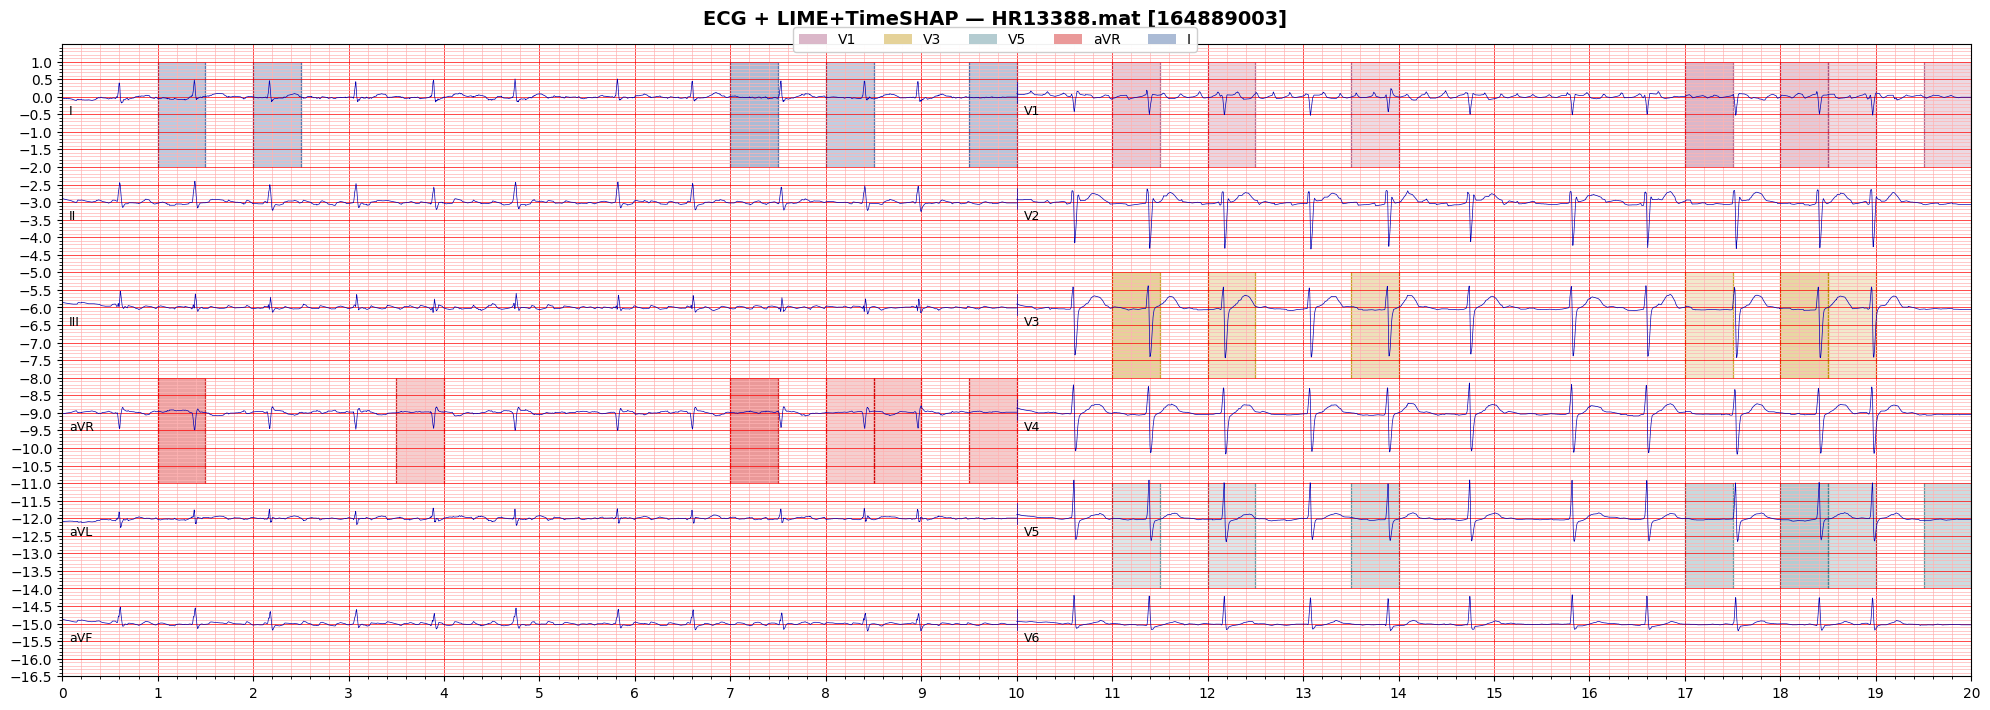

,class_code,class_name,val_idx,model_prob,top_spans,strict_attauc,lenient_attauc,strict_p_at_k,lenient_p_at_k,deletion_auc,faithfulness_gain
0,164889003,atrial fibrillation,34577,0.999914,[],0.870248,0.668647,0.45,1.0,0.299754,0.00079


Demo pick → class=426783006 | val_idx=39117 | prob=0.9957
Computed demo explanation (1 record): LIME=1.5s | TimeSHAP=1.3s


<Figure size 2000x600 with 0 Axes>

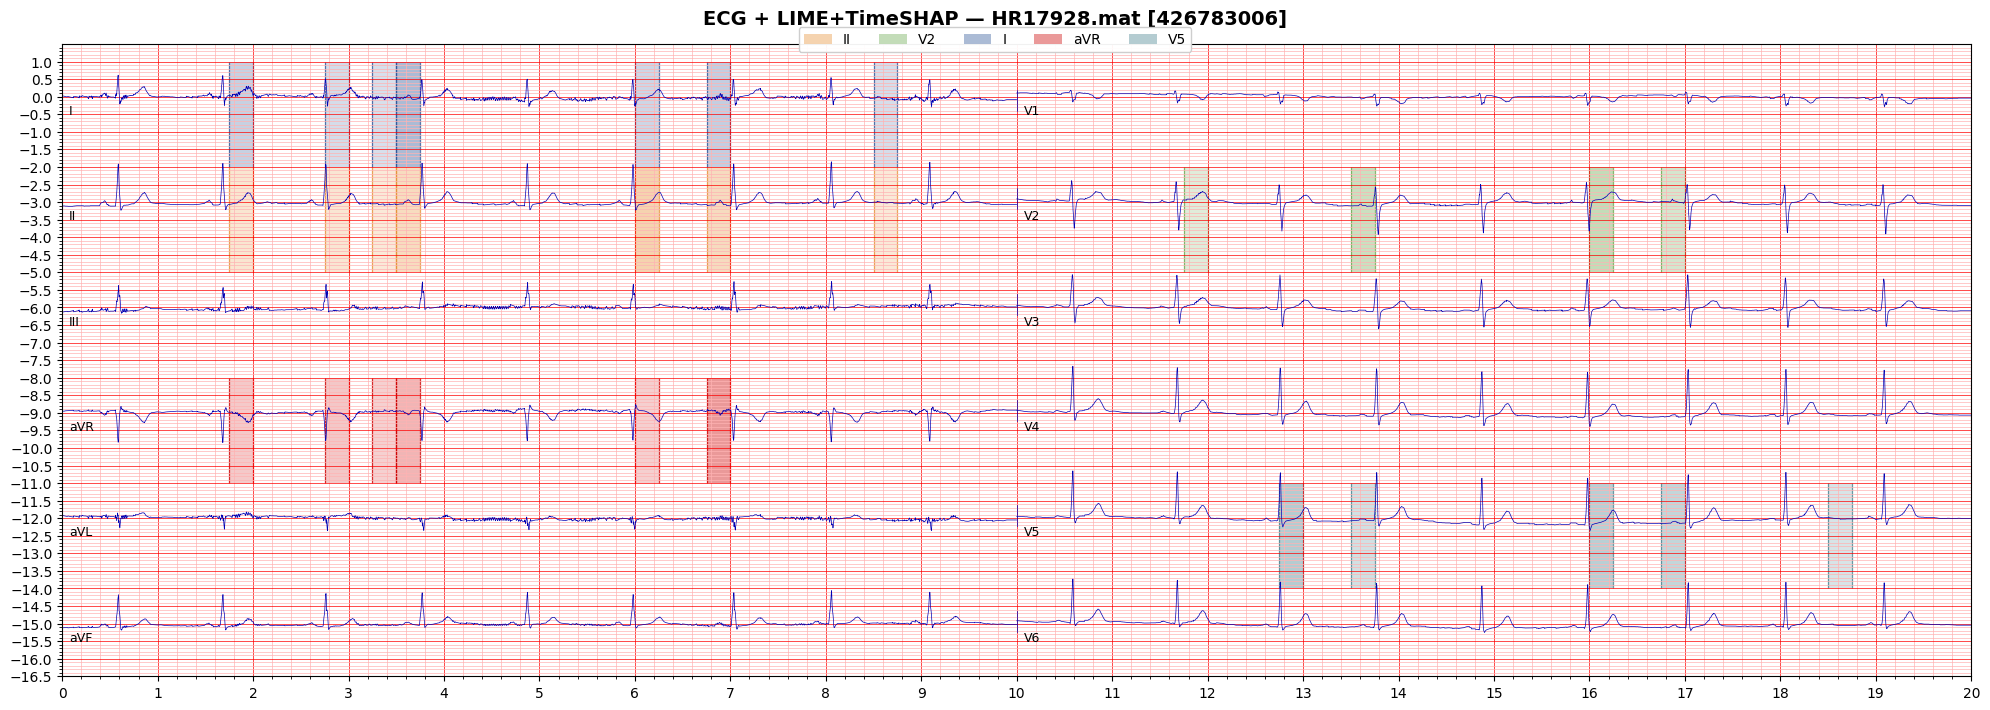

,class_code,class_name,val_idx,model_prob,top_spans,strict_attauc,lenient_attauc,strict_p_at_k,lenient_p_at_k,deletion_auc,faithfulness_gain
0,426783006,sinus rhythm,39117,0.995703,[],0.858642,1.0,0.45,1.0,0.298085,0.00156


In [17]:
# "164889003": Atrial fibrillation (AF)
# "426783006": Sinus rhythm (SNR)

for c in ["164889003", "426783006"]:
    display(run_demo_for_class(c))

## 6) Run LIME and TimeSHAP Explanations

In [18]:
from pathlib import Path
import joblib

LIME_DF_PATH = META_IN / "df_lime_all.pkl"
TS_DF_PATH   = META_IN / "df_ts_all.pkl"
FUSED_PATH   = META_IN / "fused_payloads.pkl"  # dict[class_code -> dict[val_idx -> payload]]


### 6.1 - LIME stage

In [19]:
from ecgxai.ecg_lime import run_lime_for_one_class_from_sel
from ecgxai.explainer import default_explainer_config  # uses per-class window/priors

target_classes = list(TARGET_META.keys())

if LIME_DF_PATH.exists():
    df_lime_all = joblib.load(LIME_DF_PATH)
    print("Loaded LIME:", LIME_DF_PATH)
else:
    lime_dfs = []
    for cls in target_classes:
        cfg = default_explainer_config(cls)
        df_l = run_lime_for_one_class_from_sel(
            sel_df=sel_df,
            class_name=cls,
            model=model,
            class_names=class_names,
            window_sec=cfg["window_sec"],
            m_event=cfg["m_event"],
            m_feat=cfg["m_feat"],
            topk_events=cfg["topk_events"],
            explain_class="force",
            mode=cfg["mode"],
            rng=42,
            params=cfg.get("params"),
        )
        # demo cap (optional)
        if CFG.max_examples_per_class is not None:
            df_l = df_l.head(CFG.max_examples_per_class).reset_index(drop=True)
        lime_dfs.append(df_l)

    df_lime_all = pd.concat(lime_dfs, ignore_index=True)
    joblib.dump(df_lime_all, LIME_DF_PATH)
    print("Saved LIME:", LIME_DF_PATH)

df_lime_all.head()


Loaded LIME: /kaggle/input/metadata/df_lime_all.pkl


,group_class,val_idx,filename,hea_path,mat_path,fs,window_sec,target_class_explained,event_importances_json,segments_json,window_size_samples,num_segments,top_events_idx_json,top5_lead_idx_json,perlead_spans_top5_json,lead_names
0,164889003,3890,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.50,1,"[0.026053059846162796, 0.08252786099910736, 0....","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[6, 18, 2, 16, 10]","[6, 2, 1, 7, 5]","{""6"": [[3.0, 3.5, 0.021298427134752274], [9.0,...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
1,164889003,3955,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.50,1,"[0.03633839637041092, 0.03085576929152012, 0.0...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[14, 2, 6, 15, 16]","[6, 7, 5, 2, 9]","{""6"": [[7.0, 7.5, 0.012964881956577301], [1.0,...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
2,164889003,4247,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.50,1,"[0.06085970625281334, 0.0850999504327774, -0.0...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[13, 11, 17, 19, 9]","[7, 1, 2, 6, 4]","{""7"": [[6.5, 7.0, -0.023582149296998978], [5.5...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
3,426783006,10056,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.25,21,"[-0.05065718665719032, -0.018073206767439842, ...","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[0, 14, 11, 19, 2]","[1, 0, 7, 2, 8]","{""1"": [[0.0, 0.25, 0.005026663187891245], [3.5...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
4,426783006,21532,/kaggle/input/ptbxl-electrocardiography-databa...,/kaggle/input/ptbxl-electrocardiography-databa...,/kaggle/input/ptbxl-electrocardiography-databa...,500.0,0.25,21,"[-0.009480278939008713, -0.0032611184287816286...","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[22, 4, 7, 11, 34]","[7, 1, 3, 8, 9]","{""7"": [[5.5, 5.75, 0.0059454236179590225], [1....","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"


### 6.2) TimeSHAP stage

In [20]:
from ecgxai.ecg_timeshap import run_timeshap_for_one_class_from_sel
from ecgxai.explainer import default_explainer_config

if TS_DF_PATH.exists():
    df_ts_all = joblib.load(TS_DF_PATH)
    print("Loaded TimeSHAP:", TS_DF_PATH)
else:
    ts_dfs = []
    for cls in target_classes:
        cfg = default_explainer_config(cls)
        df_t = run_timeshap_for_one_class_from_sel(
            sel_df=sel_df,
            class_name=cls,
            model=model,
            class_names=class_names,
            window_sec=cfg["window_sec"],
            m_event=cfg["m_event"],
            m_feat=cfg["m_feat"],
            topk_events=cfg["topk_events"],
            explain_class="force",
            mode=cfg["mode"],
            rng=42,
            link="logit",
            params=cfg.get("params"),
        )
        if CFG.max_examples_per_class is not None:
            df_t = df_t.head(CFG.max_examples_per_class).reset_index(drop=True)
        ts_dfs.append(df_t)

    df_ts_all = pd.concat(ts_dfs, ignore_index=True)
    joblib.dump(df_ts_all, TS_DF_PATH)
    print("Saved TimeSHAP:", TS_DF_PATH)

df_ts_all.head()

Loaded TimeSHAP: /kaggle/input/metadata/df_ts_all.pkl


,group_class,val_idx,filename,hea_path,mat_path,fs,window_sec,target_class_explained,timeshap_event_values_json,segments_json,window_size_samples,num_segments,top_events_idx_json,top5_lead_idx_json,perlead_timeshap_top5_json,lead_names,link,mode
0,164889003,3890,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.50,1,"[0.19784380495548248, 0.38970381021499634, 0.5...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[16, 6, 2, 10, 18]","[6, 1, 7, 10, 11]","{""6"": [[8.0, 8.5, 0.3606622517108917], [3.0, 3...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
1,164889003,3955,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.50,1,"[0.3213769495487213, 0.20936784148216248, 0.42...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[3, 14, 16, 17, 18]","[6, 1, 5, 10, 7]","{""6"": [[1.5, 2.0, 0.3295483887195587], [7.0, 7...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
2,164889003,4247,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.50,1,"[0.30722469091415405, 0.40043169260025024, -0....","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[17, 13, 11, 19, 1]","[6, 1, 11, 10, 8]","{""6"": [[8.5, 9.0, 0.21949432790279388], [6.5, ...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
3,426783006,10056,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,/kaggle/input/china-physiological-signal-chall...,500.0,0.25,21,"[-0.23817119002342224, -0.1375303715467453, 0....","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[36, 8, 25, 21, 10]","[6, 3, 0, 7, 11]","{""6"": [[9.0, 9.25, -0.062152400612831116], [2....","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
4,426783006,21532,/kaggle/input/ptbxl-electrocardiography-databa...,/kaggle/input/ptbxl-electrocardiography-databa...,/kaggle/input/ptbxl-electrocardiography-databa...,500.0,0.25,21,"[-0.25489774346351624, -0.11033029854297638, 0...","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[29, 22, 0, 7, 34]","[6, 3, 9, 11, 1]","{""6"": [[7.25, 7.5, -0.07774270325899124], [5.5...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context


### 6.3 - Run fused LIME + TimeSHAP pipeline

<Figure size 2000x600 with 0 Axes>

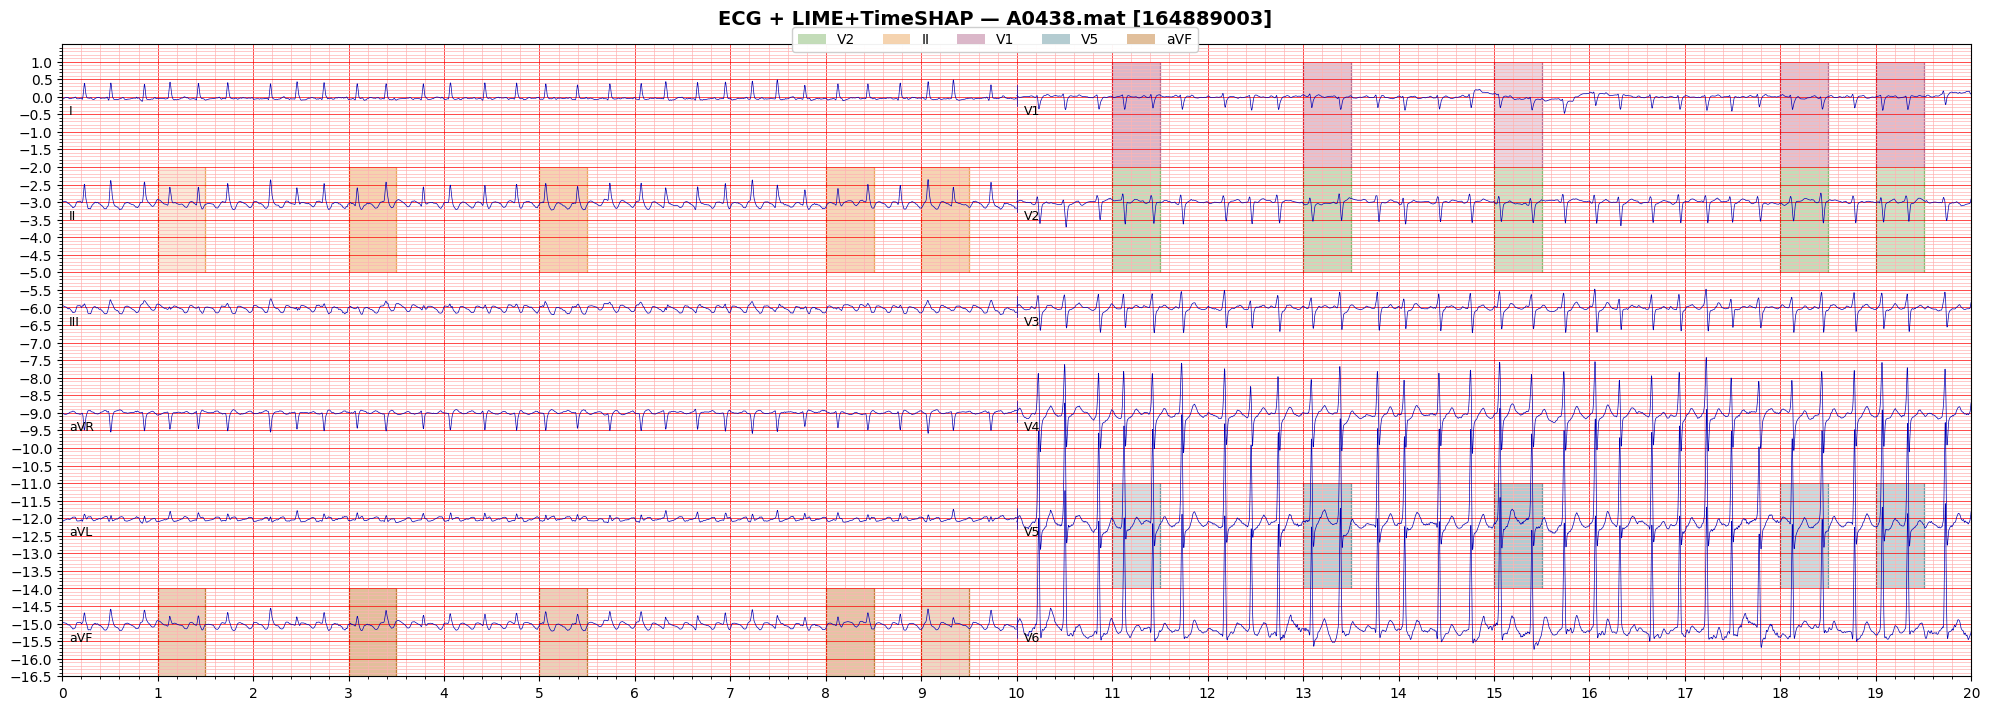

<Figure size 2000x600 with 0 Axes>

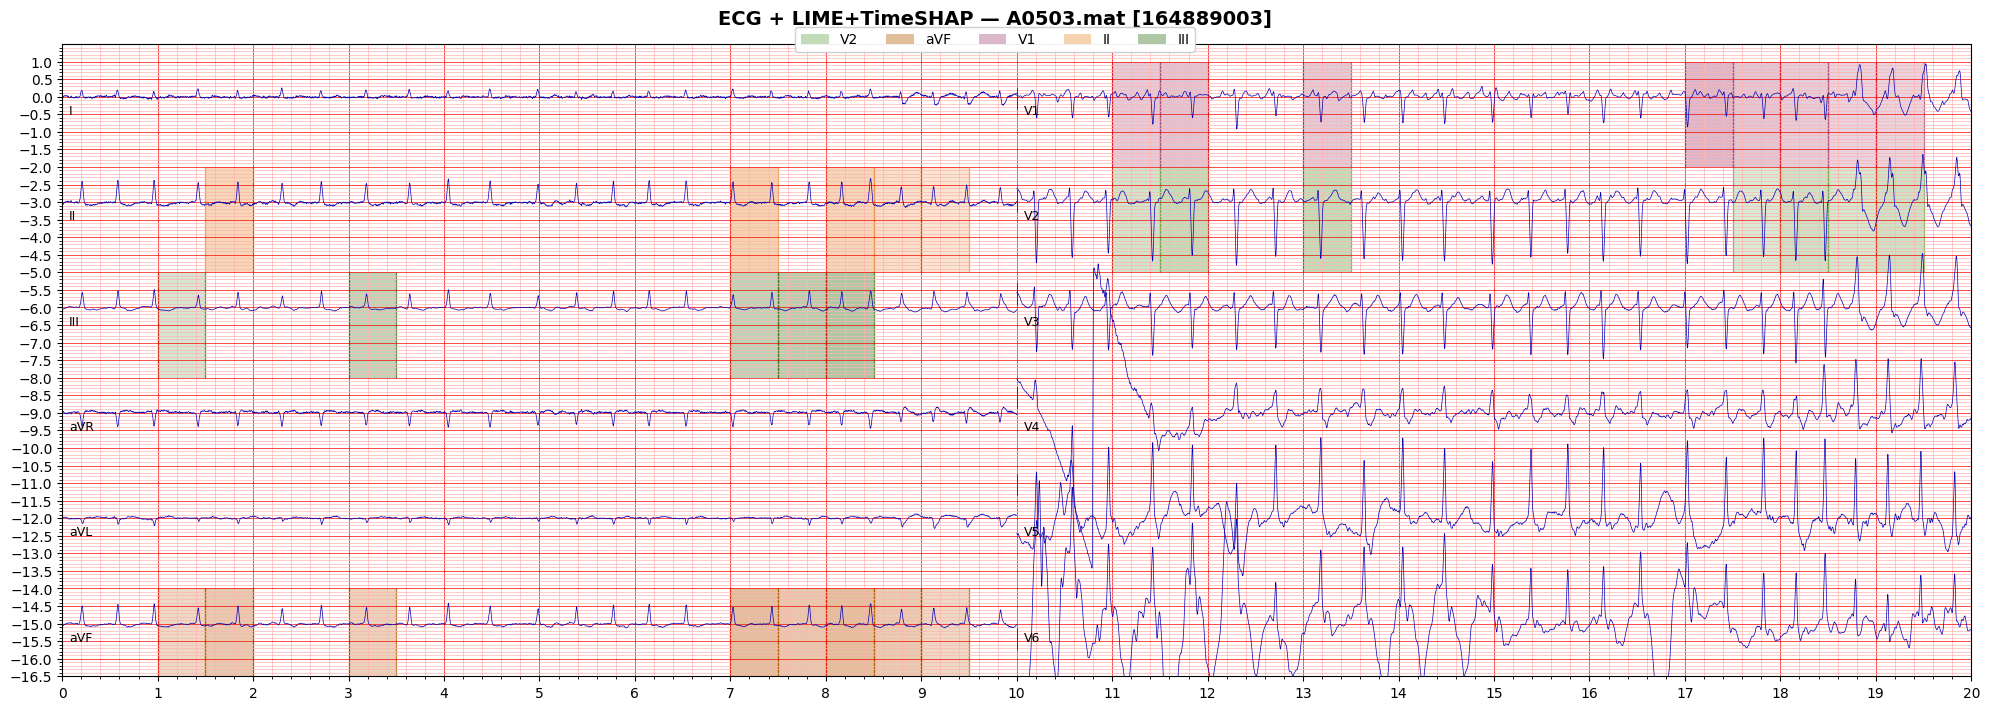

<Figure size 2000x600 with 0 Axes>

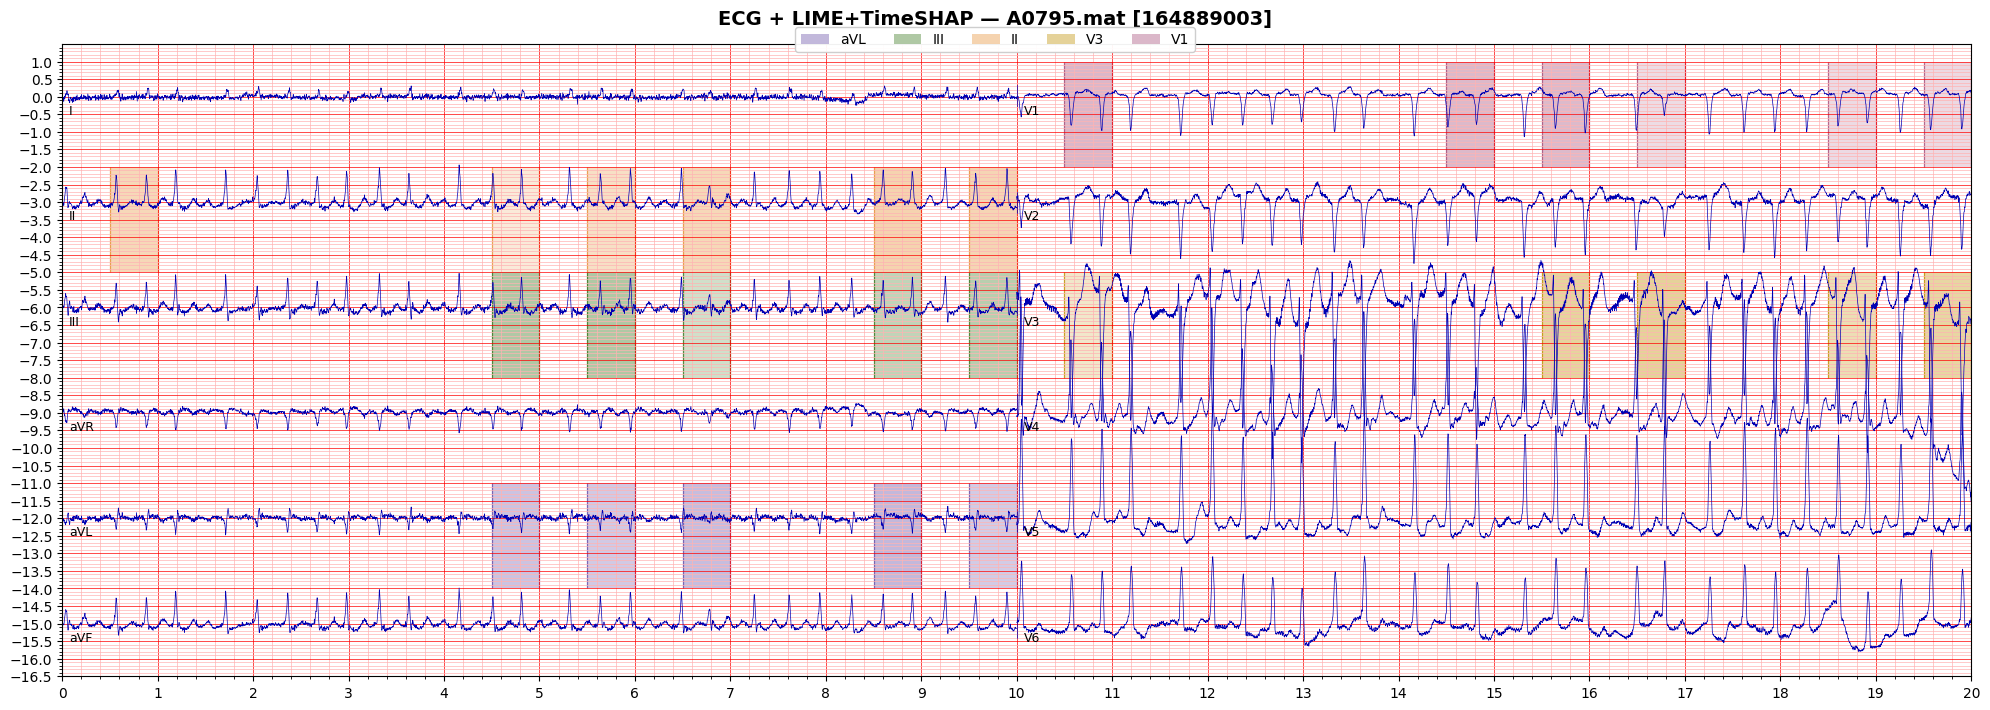

<Figure size 2000x600 with 0 Axes>

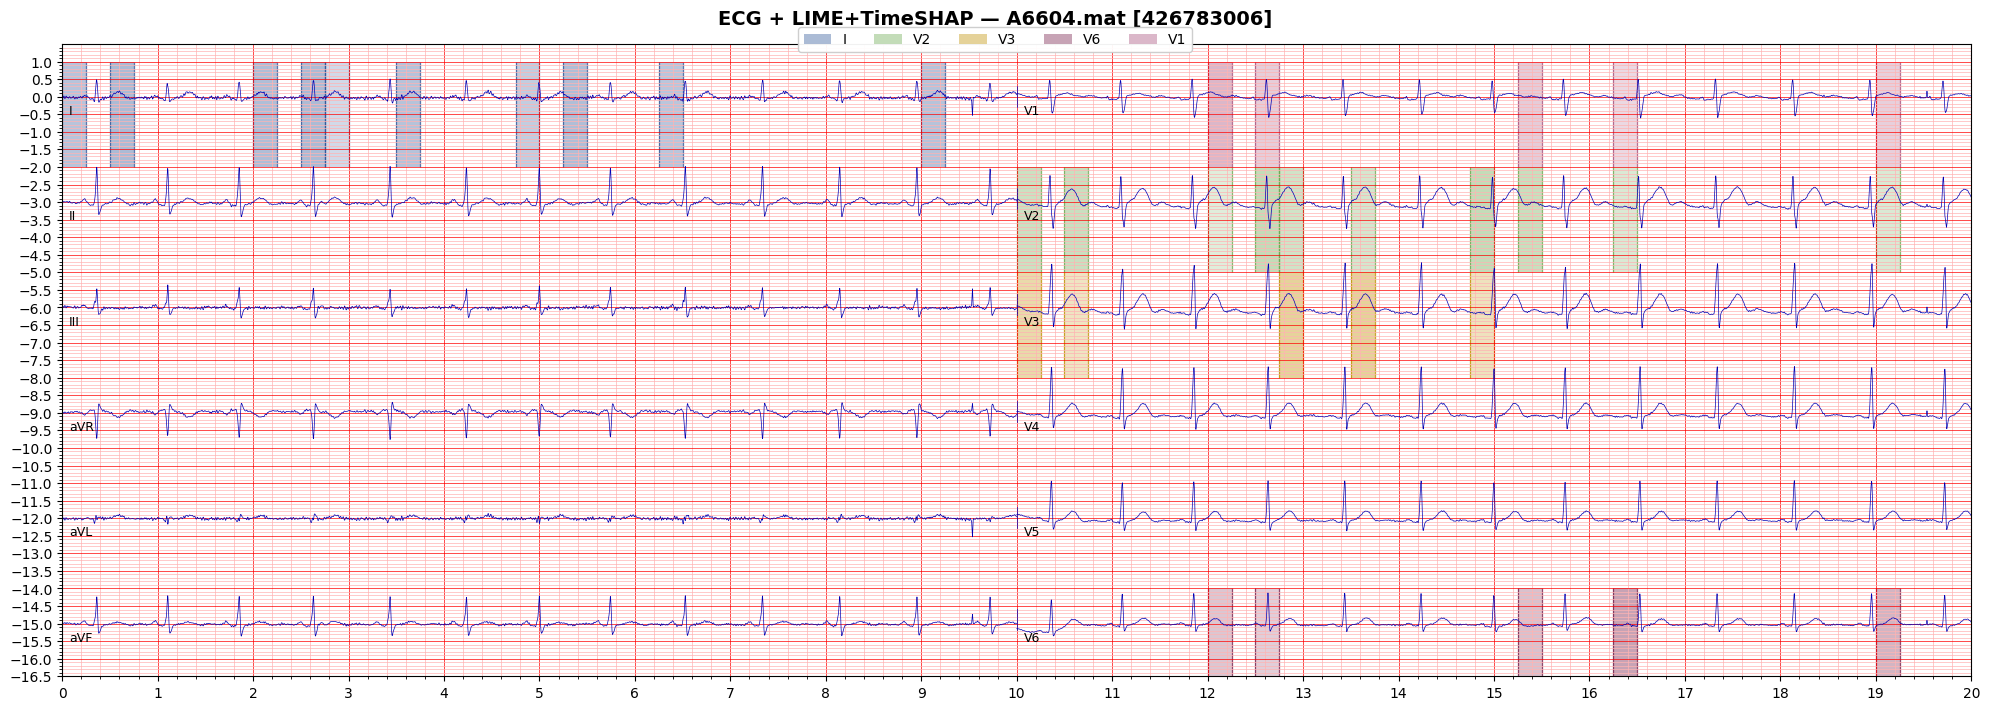

<Figure size 2000x600 with 0 Axes>

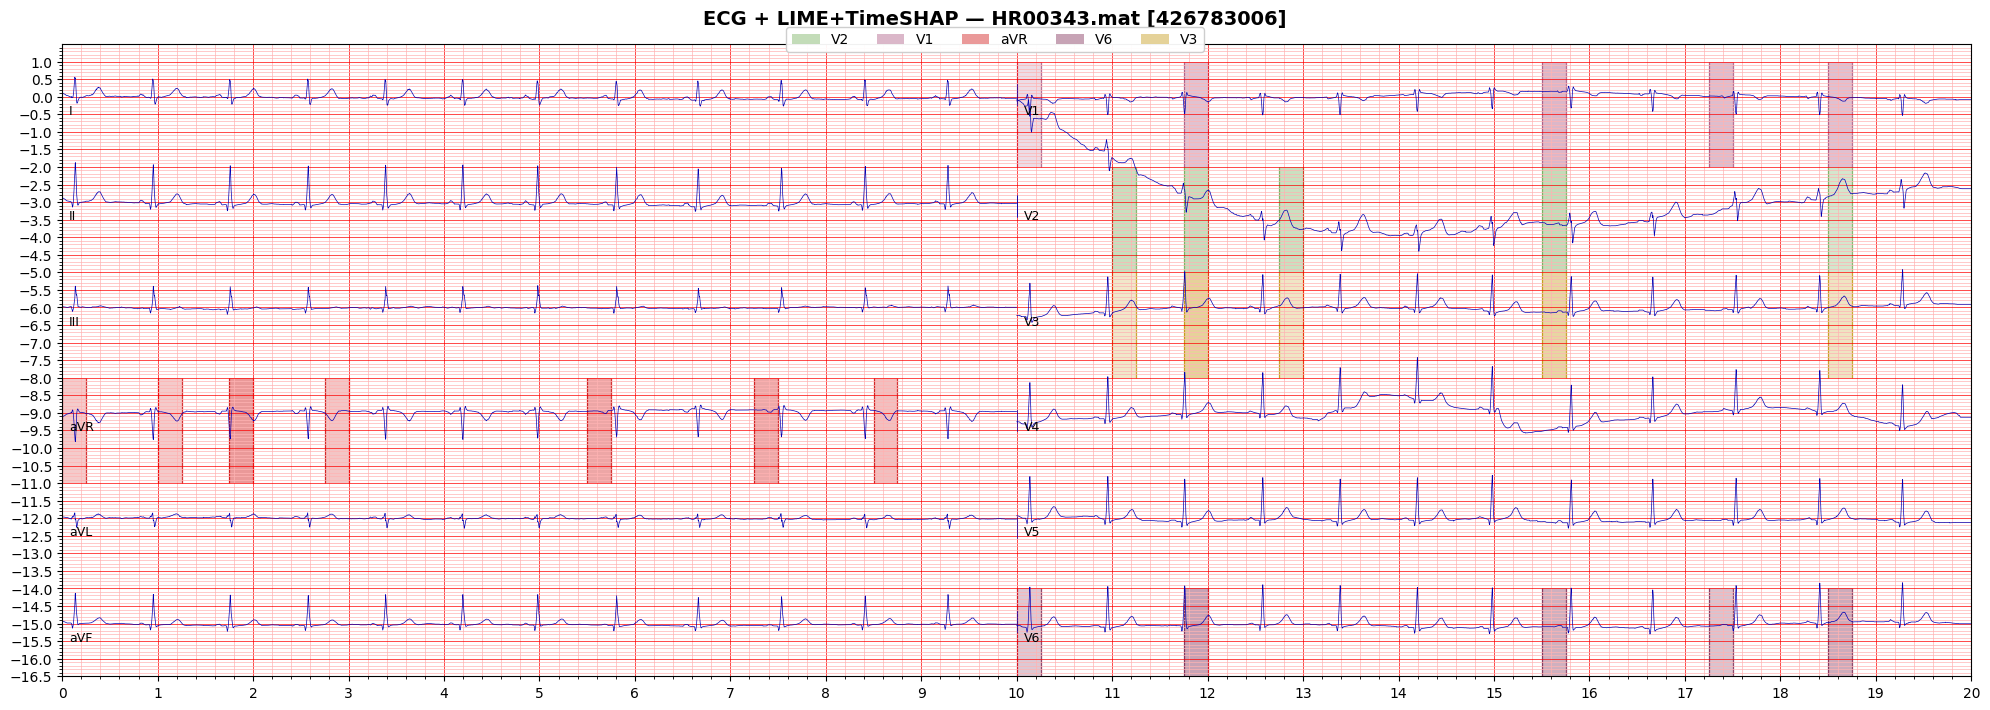

<Figure size 2000x600 with 0 Axes>

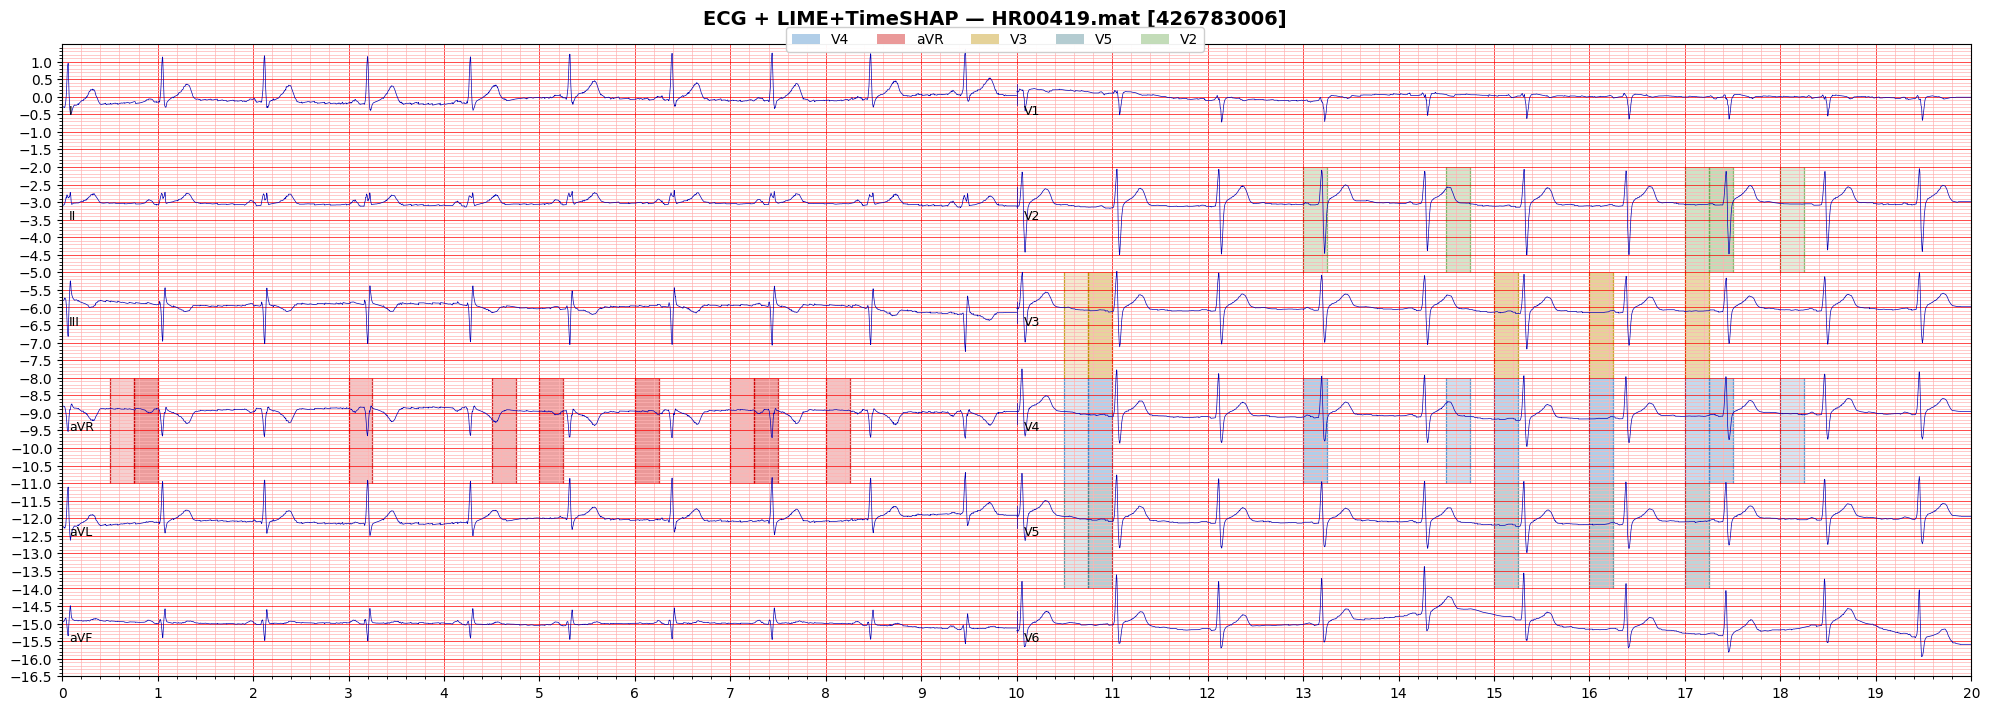

In [21]:
from ecgxai.payload import payload_from_lime_row, payload_from_timeshap_row
from ecgxai.fusion import fuse_lime_timeshap_payload
from ecgxai.plot import plot_from_payload

all_fused_payloads = {}

for cls in target_classes:
    L = df_lime_all[df_lime_all["group_class"].astype(str) == str(cls)].copy()
    T = df_ts_all[df_ts_all["group_class"].astype(str) == str(cls)].copy()

    if L.empty or T.empty:
        all_fused_payloads[str(cls)] = {}
        continue

    # common ids
    common = sorted(set(L["val_idx"].astype(int)) & set(T["val_idx"].astype(int)))
    fused_cls = {}

    for val_i in common:
        row_L = L.loc[L["val_idx"].astype(int) == val_i].iloc[0]
        row_T = T.loc[T["val_idx"].astype(int) == val_i].iloc[0]

        payload_L = payload_from_lime_row(row_L, label_for_title=row_L.get("group_class", str(cls)))
        payload_T = payload_from_timeshap_row(row_T, label_for_title=row_T.get("group_class", str(cls)))

        # optional per-class weights (same idea as your explainer.py)
        method_weights = (0.5, 0.5)
        if str(cls) == "426783006":  # sinus rhythm
            method_weights = (0.7, 0.3)

        payload_F = fuse_lime_timeshap_payload(
            payload_L, payload_T,
            agg="geomean",
            beta=1.0,
            tau=0.02,
            topk=5,
            method_weights=method_weights,
        )

        fused_cls[int(val_i)] = payload_F

        if CFG.plot:
            plot_from_payload(payload_F)

    all_fused_payloads[str(cls)] = fused_cls

# joblib.dump(all_fused_payloads, FUSED_PATH)
# print("Saved fused payloads:", FUSED_PATH)

## 7) Evaluate explanations

In [22]:
# --- 13) Evaluate all payloads ---
df_eval_all = evaluate_all_payloads(
    all_payloads=all_fused_payloads,
    method_label="LIME+TimeSHAP",
    model=model,
    class_names=class_names,
)

df_eval_all.to_csv(EVAL_CSV_PATH, index=False)
print("Saved:", EVAL_CSV_PATH)

df_eval_all

Saved: /kaggle/working/outputs/df_eval_attauc_deletion.csv


,meta_code,class_name,sel_idx,mat_path,method,strict_attauc,lenient_attauc,precision_k,strict_p_at_k,lenient_p_at_k,deletion_auc,faithfulness_gain,n_tokens
0,164889003,atrial fibrillation,3890,/kaggle/input/china-physiological-signal-chall...,LIME+TimeSHAP,0.850000,0.6250,20,0.30,0.85,0.290526,0.000000,36
1,164889003,atrial fibrillation,3955,/kaggle/input/china-physiological-signal-chall...,LIME+TimeSHAP,0.846960,0.6298,20,0.35,0.85,0.261496,0.133405,300
2,164889003,atrial fibrillation,4247,/kaggle/input/china-physiological-signal-chall...,LIME+TimeSHAP,0.891838,0.5945,20,0.50,0.70,0.228800,0.117447,324
3,426783006,sinus rhythm,10056,/kaggle/input/china-physiological-signal-chall...,LIME+TimeSHAP,0.839793,1.0000,20,0.20,1.00,0.264843,0.035505,156
4,426783006,sinus rhythm,21532,/kaggle/input/ptbxl-electrocardiography-databa...,LIME+TimeSHAP,0.882465,1.0000,20,0.40,1.00,0.282114,0.011988,144
5,426783006,sinus rhythm,21608,/kaggle/input/ptbxl-electrocardiography-databa...,LIME+TimeSHAP,0.815000,1.0000,20,0.30,1.00,0.292130,0.011476,120


## 8) Stability to an extra heartbeat

We assess stability under a synthetic perturbation where one existing beat is duplicated and inserted at the **middle** of the recording.

For each target class:
- take up to `CFG.max_examples_per_class` examples (from the evaluation table),
- run the extra-beat augmentation + fused explainability,
- compute region-level agreement metrics (Spearman, Jaccard@K, etc.).

In [23]:
# --- Extra-beat stability experiment ---
MAX_PER_CLASS = CFG.max_examples_per_class
BASE_SEED = CFG.seed

stability_rows = []

df_eval = df_eval_all.copy()
df_eval["meta_code"] = df_eval["meta_code"].astype(str)

for meta_code_str, df_cls in df_eval.groupby("meta_code", sort=False):
    class_name = str(TARGET_META[str(meta_code_str)]["name"])

    # Skip already-augmented mats (optional)
    df_cls = df_cls[~df_cls["mat_path"].str.contains(r"_extra_.*\.mat$", case=False, na=False)]

    if MAX_PER_CLASS is not None:
        df_cls = df_cls.head(MAX_PER_CLASS)

    print(f"\n=== Class {meta_code_str} ({class_name}) | n={len(df_cls)} ===")

    for _, row in df_cls.iterrows():
        mat_path = row["mat_path"]
        sel_idx  = int(row.get("sel_idx", 0))

        # deterministic per record
        seed = (int(BASE_SEED) ^ (zlib.crc32(mat_path.encode("utf-8")) & 0xFFFFFFFF)) & 0xFFFFFFFF
        print(f"  -> [{meta_code_str}] sel_idx={sel_idx} | seed={seed} | {mat_path}")

        try:
            metrics, *_ = run_extra_beat_stability_experiment(
                mat_path=mat_path,
                snomed_code=str(meta_code_str),
                model=model,
                class_names=class_names,
                augment_root=STAB_OUT_DIR,
                seed=seed,
            )

            extra = (metrics.get("extra") or {})
            stability_rows.append({
                "meta_code": str(meta_code_str),
                "class_name": class_name,
                "sel_idx": sel_idx,
                "mat_path": mat_path,
                "seed": seed,
                "augment_beat_index": metrics.get("augment_beat_index"),
                "augmented_file": metrics.get("augmented_file"),
                "extra_spearman": extra.get("spearman"),
                "extra_jaccard": extra.get("jaccard_topk"),
                "extra_rbo": extra.get("rbo"),
                "extra_wjacc": extra.get("weighted_jaccard"),
                "extra_k_eff": extra.get("k_eff"),
            })
        except Exception as e:
            stability_rows.append({
                "meta_code": str(meta_code_str),
                "class_name": class_name,
                "sel_idx": sel_idx,
                "mat_path": mat_path,
                "seed": seed,
                "error": repr(e),
            })
            print("failed:", e)

df_stability = pd.DataFrame(stability_rows)
df_stability.to_csv(STAB_CSV_PATH, index=False)
print("Saved:", STAB_CSV_PATH)

df_stability



=== Class 164889003 (atrial fibrillation) | n=3 ===
  -> [164889003] sel_idx=3890 | seed=2388742391 | /kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A0438.mat
FUSED 164889003 | n=2 | win=0.5s mE=100 mF=100 topkE=5 | LIME=0m02s TS=0m02s | fused=2 | total=0m05s
Fused pipeline complete: 1 classes in 0m05s
  -> [164889003] sel_idx=3955 | seed=3646036220 | /kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A0503.mat
FUSED 164889003 | n=2 | win=0.5s mE=100 mF=100 topkE=5 | LIME=0m02s TS=0m02s | fused=2 | total=0m05s
Fused pipeline complete: 1 classes in 0m05s
  -> [164889003] sel_idx=4247 | seed=3867323837 | /kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/A0795.mat
FUSED 164889003 | n=2 | win=0.5s mE=100 mF=100 topkE=5 | LIME=0m02s TS=0m02s | fused=2 | total=0m05s
Fused pipeline complete: 1 classes in 0m05s

=== Class 426783006 (sinus rhythm) | n=3 ===
  -> [426783006] sel_idx=10056 | seed=2633357302 | /kaggle/input/ch

,meta_code,class_name,sel_idx,mat_path,seed,augment_beat_index,augmented_file,extra_spearman,extra_jaccard,extra_rbo,extra_wjacc,extra_k_eff
0,164889003,atrial fibrillation,3890,/kaggle/input/china-physiological-signal-chall...,2388742391,22,/kaggle/working/outputs/extra_beat_aug/A0438/A...,0.868782,0.428571,0.218061,0.928132,20.0
1,164889003,atrial fibrillation,3955,/kaggle/input/china-physiological-signal-chall...,3646036220,17,/kaggle/working/outputs/extra_beat_aug/A0503/A...,0.921256,0.379310,0.283587,0.939958,20.0
2,164889003,atrial fibrillation,4247,/kaggle/input/china-physiological-signal-chall...,3867323837,18,/kaggle/working/outputs/extra_beat_aug/A0795/A...,0.943865,0.481481,0.308426,0.945145,20.0
3,426783006,sinus rhythm,10056,/kaggle/input/china-physiological-signal-chall...,2633357302,7,/kaggle/working/outputs/extra_beat_aug/A6604/A...,0.958897,1.000000,0.465829,0.964691,11.0
4,426783006,sinus rhythm,21532,/kaggle/input/ptbxl-electrocardiography-databa...,3580863227,9,/kaggle/working/outputs/extra_beat_aug/HR00343...,0.921419,1.000000,0.310415,0.958452,12.0
5,426783006,sinus rhythm,21608,/kaggle/input/ptbxl-electrocardiography-databa...,179639655,2,/kaggle/working/outputs/extra_beat_aug/HR00419...,0.937505,1.000000,0.280489,0.836411,10.0


## 9) Per-class summary (mean/std + counts)

In [24]:
metric_cols = ["extra_spearman", "extra_jaccard", "extra_rbo", "extra_wjacc", "extra_k_eff"]

# rows that succeeded (no error column or error is null)
ok = df_stability.copy()
if "error" in ok.columns:
    ok = ok[ok["error"].isna()]

summary = (ok.groupby(["meta_code", "class_name"])
           .agg(
               n=("mat_path", "count"),
               spearman_mean=("extra_spearman", "mean"),
               spearman_std=("extra_spearman", "std"),
               jaccard_mean=("extra_jaccard", "mean"),
               jaccard_std=("extra_jaccard", "std"),
               rbo_mean=("extra_rbo", "mean"),
               wjacc_mean=("extra_wjacc", "mean"),
               k_eff_mean=("extra_k_eff", "mean"),
           )
           .reset_index()
           .sort_values(["meta_code"]))

show = summary[["meta_code","class_name","n","spearman_mean","jaccard_mean","k_eff_mean"]]
show

,meta_code,class_name,n,spearman_mean,jaccard_mean,k_eff_mean
0,164889003,atrial fibrillation,3,0.911301,0.429788,20.0
1,426783006,sinus rhythm,3,0.939274,1.000000,11.0
